In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import splitfolders
from utils import ImportData, Metrics, plot_confusion_matrix

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import plot_model


## Loading Data with Import Data:

<b> Intiialization: </b>
<ul>
<li> <i> input_dir </i> - directory of the images which is already sorted by folders. Default = "raw_data"
<li> <i> output_dir </i> - directory you want to store the split up images. Default = "data"
</ul>

<b> Train Test Split</b>
<ul>
<li> <i> ratio </i> - Length 3 tuple for your train test and validation set. Default = "(0.8, 0.1, 0.1)"
<li> <i> SEED </i> - Default = "1234"
</ul>

<b> Load Data </b>
<ul>
<li> <i> image_size </i> -Default = (64, 64, 3)
<li> <i> augmentation_params </i> - Default = None

```python
augmentation_params = {
    "zoom_range": 0,
    "horizontal_flip": False,
    "width_shift_range": 0,
    "height_shift_range": 0
}
```
<li> <i> Batch-size </i> - Default = 100
</ul>

<b> Plot Random </b>
Randomly plots 3 objects

In [4]:
LoadData = ImportData()
#LoadData.train_test_split()
train, val, test = LoadData.load_data((224,224,3), batch_size= 32)

Found 21600 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.


In [5]:
num_classes = len(train.class_indices)
epochs = 50

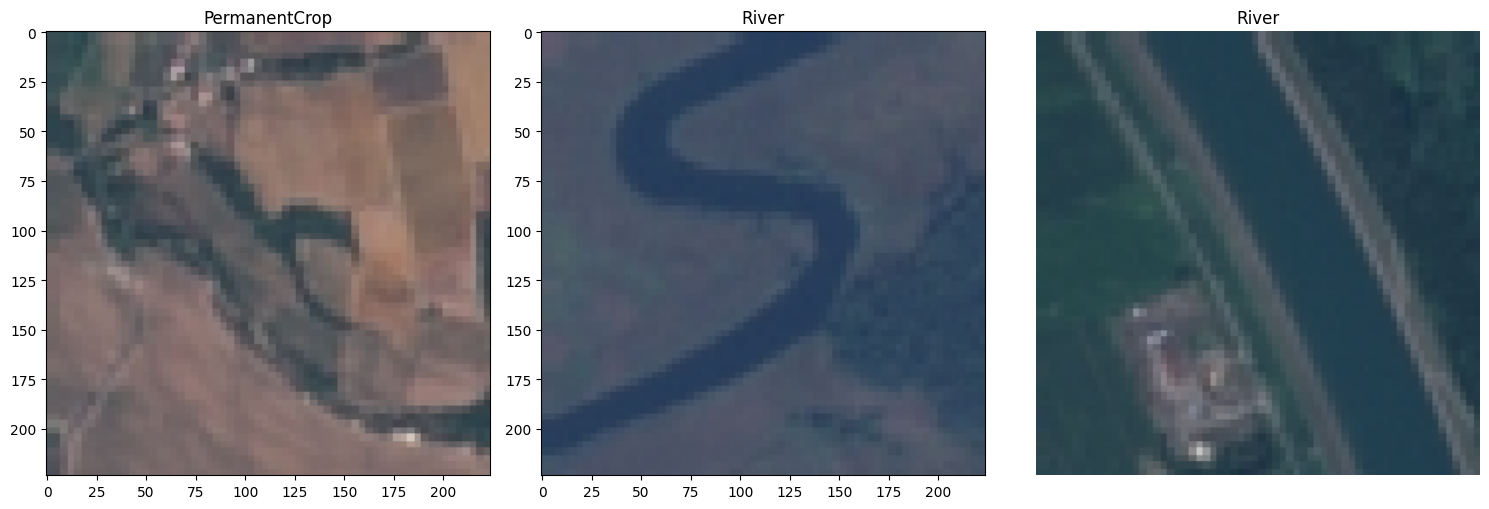

In [5]:
LoadData.plot_random()

## ResNet50

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers.legacy import Adam

In [6]:
checkpoint_filepath = "checkpoints/ResNet/{epoch:02d}-{val_accuracy:.2f}.keras"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=5, monitor="val_accuracy", mode="max"),
             model_checkpoint_callback,
]


## Defining and Training the ResNet Model

In [8]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) 
predictions = Dense(num_classes, activation='softmax')(x)  # Adjust num_classes according to your task

model = Model(inputs=resnet_base.input, outputs=predictions)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train, epochs=epochs, validation_data=val, callbacks = callbacks)

Epoch 1/50


KeyboardInterrupt: 

## Testing Predictions

In [7]:
import os
model_dir = "checkpoints/ResNet"
ResNet_model = tf.keras.models.load_model(
    os.path.join(model_dir, "17-0.94.keras")
)

2024-06-06 18:18:44.893208: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-06 18:18:44.893238: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-06 18:18:44.893244: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-06 18:18:44.893318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-06 18:18:44.893522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
test_predictions = ResNet_model.predict(test)

2024-06-06 18:19:12.539130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - 21s 188ms/step


In [16]:
test_predictions = np.argmax(test_predictions, axis = 1)

In [19]:
results = Metrics(title = "EuroSAT")
results.run(test.classes, test_predictions, method_name = "ResNet50")
results.plot()

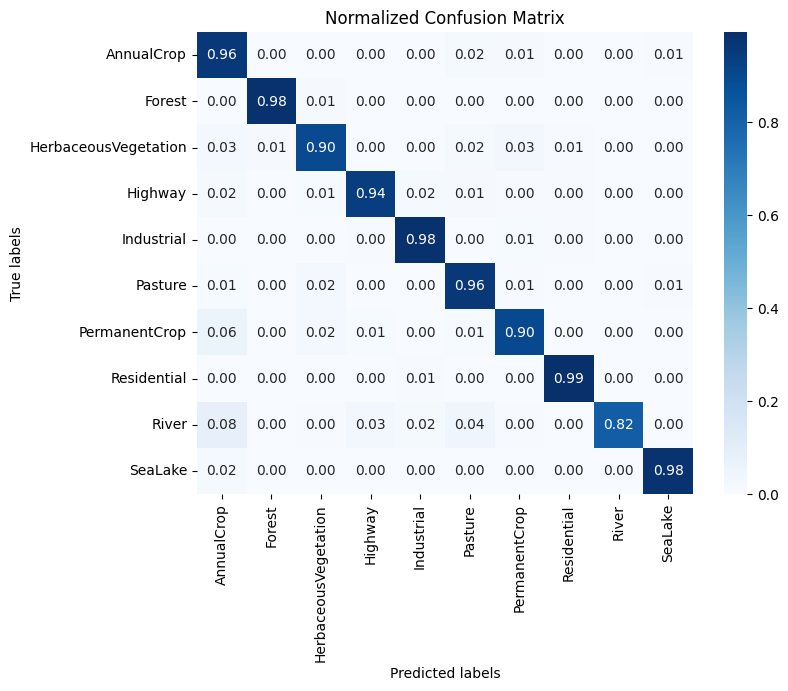

In [21]:
plot_confusion_matrix(test.classes, test_predictions, classes = test.class_indices.keys())